# Écoute ma danse

## Importer les librairies

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import fasterai
from fasterai.prune.all import *

from fastai.vision.all import *
from tqdm import tqdm

In [ ]:
path = Path('EloiStree/Final')
train_path = path/'TRAIN'
test_path = path/'TEST'

In [ ]:
# Clean bad images
bad_imgs = L()

for class_folder in tqdm(train_path.ls()):
    bad_imgs += verify_images(class_folder.ls())
    
for im in bad_imgs:
    print(im)
    im.unlink()

100%|█████████████████████████████████| 13/13 [00:11<00:00,  1.10it/s]


In [ ]:
dls = ImageDataLoaders.from_folder(path, train='TRAIN', valid='TEST', 
                                   item_tfms=Resize(224), 
                                   bs=16)

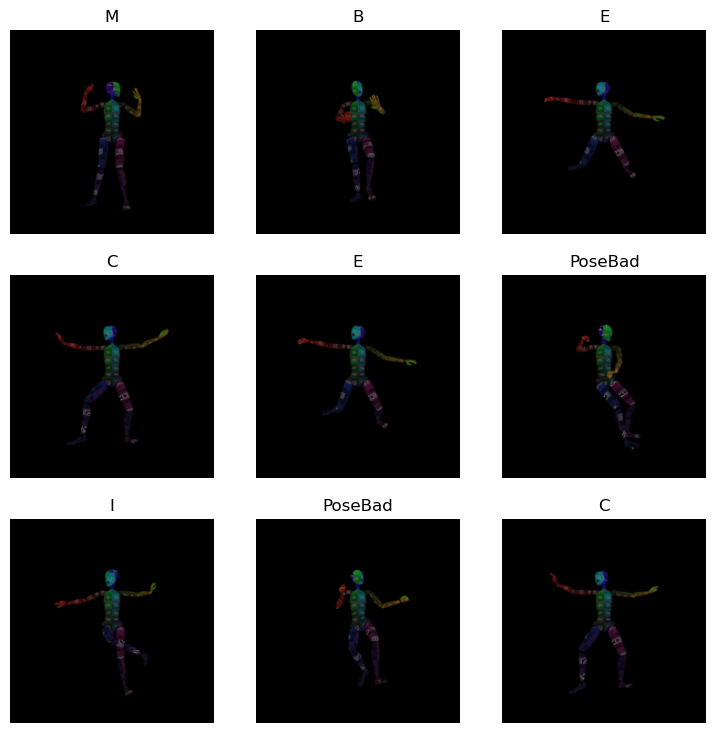

In [ ]:
dls.show_batch()

In [ ]:
# No compression
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.unfreeze()

learn.fit_one_cycle(n_epoch=5, lr_max=1e-3)

In [ ]:
# With compression

learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.unfreeze()

pr_cb = PruneCallback(sparsity=0, context='global', criteria=large_final, schedule=one_cycle)

learn.fit_one_cycle(25, 1e-3, cbs=pr_cb)

# How much Carbon emissions ?

In [ ]:
from codecarbon import EmissionsTracker

In [ ]:
tracker = EmissionsTracker()

[codecarbon INFO @ 14:26:22] [setup] RAM Tracking...
[codecarbon INFO @ 14:26:22] [setup] GPU Tracking...
[codecarbon INFO @ 14:26:22] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 14:26:22] [setup] CPU Tracking...
[codecarbon WARNING @ 14:26:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:26:23] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-6850K CPU @ 3.60GHz
[codecarbon INFO @ 14:26:23] >>> Tracker's metadata:
[codecarbon INFO @ 14:26:23]   Platform system: Linux-5.15.0-69-generic-x86_64-with-glibc2.31
[codecarbon INFO @ 14:26:23]   Python version: 3.9.0
[codecarbon INFO @ 14:26:23]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 14:26:23]   Available RAM : 62.704 GB
[codecarbon INFO @ 14:26:23]   CPU count: 12
[codecarbon INFO @ 14:26:23]   CPU model: Intel(R) Core(TM) i7-6850K CPU @ 3.60GHz
[codecarbon INFO @ 14:26:23]   GPU count: 4
[codecarbon INFO @ 14:26:23]   GPU model: 4 x NVIDIA GeForce GTX 1080 Ti


In [ ]:
x,y = dls.one_batch()

In [ ]:
tracker.start()
learn.model(x[0][None])
emissions = tracker.stop()

[codecarbon INFO @ 14:26:27] Energy consumed for RAM : 0.000000 kWh. RAM Power : 23.51403379440308 W
[codecarbon INFO @ 14:26:27] Energy consumed for all GPUs : 0.000001 kWh. Total GPU Power : 123.15509873724679 W
[codecarbon INFO @ 14:26:27] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 70.0 W
[codecarbon INFO @ 14:26:27] 0.000002 kWh of electricity used since the beginning.


In [ ]:
tracker.final_emissions_data

EmissionsData(timestamp='2023-11-19T14:26:27', project_name='codecarbon', run_id='61642ae7-598c-41dd-ab38-5f9bdb339e00', duration=0.037906646728515625, emissions=2.70927306023963e-07, emissions_rate=7.1472242840239265e-06, cpu_power=70.0, gpu_power=123.15509873724679, ram_power=23.51403379440308, cpu_energy=7.104635238647461e-07, gpu_energy=8.608340280602533e-07, ram_energy=1.5521183505683214e-07, energy_consumed=1.7265093869818317e-06, country_name='Belgium', country_iso_code='BEL', region='wallonia', cloud_provider='', cloud_region='', os='Linux-5.15.0-69-generic-x86_64-with-glibc2.31', python_version='3.9.0', codecarbon_version='2.3.1', cpu_count=12, cpu_model='Intel(R) Core(TM) i7-6850K CPU @ 3.60GHz', gpu_count=4, gpu_model='4 x NVIDIA GeForce GTX 1080 Ti', longitude=3.9524, latitude=50.458, ram_total_size=62.7040901184082, tracking_mode='machine', on_cloud='N', pue=1.0)

In [ ]:
print(f"Total emissions for this inference: {emissions} kg")

Total emissions for this inference: 2.70927306023963e-07 kg


[codecarbon INFO @ 14:26:27] Energy consumed for RAM : 0.000979 kWh. RAM Power : 23.51403379440308 W
[codecarbon INFO @ 14:26:27] Energy consumed for all GPUs : 0.002593 kWh. Total GPU Power : 68.29687220935229 W
[codecarbon INFO @ 14:26:27] Energy consumed for all CPUs : 0.002917 kWh. Total CPU Power : 70.0 W
[codecarbon INFO @ 14:26:27] 0.006489 kWh of electricity used since the beginning.


## Get predictions on final sequence

In [ ]:
def get_predictions(image_path):
    img = PILImage.create(image_path)
    pred, _, probs = learn.predict(img)
    return probs.numpy()

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
import pandas as pd
import os

image_folder = 'EloiStree/Final/20FPSScenario'

for image_file in tqdm(os.listdir(image_folder)):
    if image_file.endswith('.png'):
        image_path = os.path.join(image_folder, image_file)
        predictions = get_predictions(image_path)

        data = [[predictions[i]] for i in range(len(predictions))]
        
        df = pd.DataFrame(data, columns=['Probability'])
        df['Class'] = dls.vocab
        csv_path = os.path.splitext(image_path)[0] + '.csv'
        df.to_csv(csv_path, index=False, float_format='%.3f')

  0%|                                        | 0/8162 [00:00<?, ?it/s]

  0%|                                | 2/8162 [00:00<09:40, 14.06it/s]

  0%|                                | 5/8162 [00:00<07:50, 17.33it/s]

  0%|                                | 8/8162 [00:00<07:08, 19.02it/s]

  0%|                               | 11/8162 [00:00<06:39, 20.43it/s]

  0%|                               | 14/8162 [00:00<06:36, 20.55it/s]

  0%|                               | 17/8162 [00:00<06:24, 21.20it/s]

  0%|                               | 20/8162 [00:00<06:11, 21.92it/s]

  1%|▏                             | 61/8162 [00:01<01:14, 109.43it/s]

  1%|▎                              | 72/8162 [00:01<02:29, 53.97it/s]

  1%|▎                              | 80/8162 [00:01<03:13, 41.77it/s]

  1%|▎                              | 87/8162 [00:02<03:46, 35.64it/s]

  1%|▎                              | 92/8162 [00:02<04:11, 32.04it/s]

  1%|▎                              | 97/8162 [00:02<04:40, 28.72it/s]

  2%|▍                             | 130/8162 [00:02<01:58, 67.55it/s]

  2%|▌                             | 140/8162 [00:03<02:51, 46.90it/s]

  2%|▌                             | 148/8162 [00:03<03:25, 39.01it/s]

  2%|▌                             | 154/8162 [00:03<03:48, 35.12it/s]

  2%|▌                             | 159/8162 [00:04<04:11, 31.82it/s]

  2%|▌                             | 164/8162 [00:04<03:59, 33.35it/s]

  2%|▋                             | 184/8162 [00:04<02:17, 57.97it/s]

  2%|▋                             | 192/8162 [00:04<03:02, 43.77it/s]

  2%|▋                             | 199/8162 [00:05<03:38, 36.36it/s]

  3%|▊                             | 205/8162 [00:05<04:03, 32.64it/s]

  3%|▊                             | 210/8162 [00:05<04:32, 29.16it/s]

  3%|▊                             | 214/8162 [00:05<04:26, 29.83it/s]

  3%|▉                             | 248/8162 [00:05<01:41, 78.21it/s]

  3%|▉                             | 259/8162 [00:06<02:46, 47.44it/s]

  3%|▉                             | 267/8162 [00:06<03:23, 38.81it/s]

  4%|█                             | 291/8162 [00:06<02:08, 61.05it/s]

  4%|█                             | 301/8162 [00:07<02:54, 45.11it/s]

  4%|█▏                            | 309/8162 [00:07<03:26, 38.07it/s]

  4%|█▏                            | 338/8162 [00:07<01:58, 66.13it/s]

  4%|█▎                            | 350/8162 [00:08<02:54, 44.87it/s]

  4%|█▎                            | 359/8162 [00:08<03:32, 36.68it/s]

  4%|█▎                            | 366/8162 [00:08<03:54, 33.30it/s]

  5%|█▍                            | 391/8162 [00:09<02:17, 56.67it/s]

  5%|█▍                            | 402/8162 [00:09<03:01, 42.67it/s]

  5%|█▌                            | 411/8162 [00:09<03:39, 35.33it/s]

  5%|█▌                            | 418/8162 [00:10<03:25, 37.75it/s]

  5%|█▌                            | 440/8162 [00:10<02:10, 59.08it/s]

  6%|█▋                            | 450/8162 [00:10<03:02, 42.17it/s]

  6%|█▋                            | 458/8162 [00:11<03:41, 34.84it/s]

  6%|█▋                            | 464/8162 [00:11<04:00, 31.99it/s]

  6%|█▋                            | 469/8162 [00:11<04:18, 29.77it/s]

  6%|█▋                            | 473/8162 [00:11<04:40, 27.37it/s]

  6%|█▊                            | 508/8162 [00:11<01:49, 69.60it/s]

  6%|█▉                            | 519/8162 [00:12<02:44, 46.53it/s]

  6%|█▉                            | 527/8162 [00:12<03:20, 38.04it/s]

  7%|█▉                            | 534/8162 [00:13<03:43, 34.09it/s]

  7%|█▉                            | 539/8162 [00:13<04:06, 30.90it/s]

  7%|██                            | 568/8162 [00:13<02:03, 61.49it/s]

  7%|██                            | 578/8162 [00:13<02:46, 45.44it/s]

  7%|██▏                           | 586/8162 [00:14<03:18, 38.13it/s]

  7%|██▏                           | 592/8162 [00:14<03:45, 33.58it/s]

  7%|██▏                           | 597/8162 [00:14<04:02, 31.17it/s]

  7%|██▏                           | 601/8162 [00:14<04:13, 29.78it/s]

  7%|██▏                           | 605/8162 [00:14<04:12, 29.93it/s]

  8%|██▎                           | 636/8162 [00:15<01:42, 73.36it/s]

  8%|██▎                           | 646/8162 [00:15<02:33, 48.84it/s]

  8%|██▍                           | 654/8162 [00:15<03:08, 39.94it/s]

  8%|██▍                           | 660/8162 [00:16<03:34, 34.91it/s]

  8%|██▍                           | 679/8162 [00:16<02:15, 55.34it/s]

  8%|██▌                           | 688/8162 [00:16<02:58, 41.81it/s]

  9%|██▌                           | 695/8162 [00:16<03:26, 36.08it/s]

  9%|██▌                           | 701/8162 [00:17<03:41, 33.70it/s]

  9%|██▋                           | 724/8162 [00:17<02:05, 59.21it/s]

  9%|██▋                           | 733/8162 [00:17<02:53, 42.93it/s]

  9%|██▋                           | 740/8162 [00:17<03:25, 36.17it/s]

  9%|██▋                           | 746/8162 [00:18<03:48, 32.43it/s]

  9%|██▊                           | 751/8162 [00:18<04:11, 29.44it/s]

 10%|██▊                           | 777/8162 [00:18<02:07, 58.04it/s]

 10%|██▉                           | 786/8162 [00:19<02:52, 42.65it/s]

 10%|██▉                           | 793/8162 [00:19<03:17, 37.32it/s]

 10%|██▉                           | 799/8162 [00:19<03:38, 33.70it/s]

 10%|██▉                           | 804/8162 [00:19<03:43, 32.92it/s]

 10%|███                           | 834/8162 [00:19<01:44, 69.82it/s]

 10%|███                           | 844/8162 [00:20<02:32, 47.97it/s]

 10%|███▏                          | 852/8162 [00:20<03:10, 38.35it/s]

 11%|███▏                          | 858/8162 [00:20<03:40, 33.13it/s]

 11%|███▏                          | 863/8162 [00:21<03:37, 33.58it/s]

 11%|███▎                          | 892/8162 [00:21<01:46, 68.19it/s]

 11%|███▎                          | 902/8162 [00:21<02:34, 46.96it/s]

 11%|███▎                          | 910/8162 [00:21<02:25, 49.93it/s]

 11%|███▍                          | 934/8162 [00:21<01:34, 76.69it/s]

 12%|███▍                          | 945/8162 [00:22<02:26, 49.12it/s]

 12%|███▌                          | 954/8162 [00:22<02:16, 52.76it/s]

 12%|███▌                          | 972/8162 [00:22<01:44, 68.75it/s]

 12%|███▌                          | 982/8162 [00:23<02:33, 46.70it/s]

 12%|███▋                          | 990/8162 [00:23<03:06, 38.52it/s]

 12%|███▋                          | 996/8162 [00:23<03:32, 33.71it/s]

 12%|███▌                         | 1001/8162 [00:23<03:50, 31.09it/s]

 12%|███▌                         | 1006/8162 [00:24<03:41, 32.32it/s]

 13%|███▋                         | 1044/8162 [00:24<01:25, 83.50it/s]

 13%|███▊                         | 1056/8162 [00:24<02:20, 50.59it/s]

 13%|███▊                         | 1065/8162 [00:25<02:51, 41.39it/s]

 13%|███▊                         | 1072/8162 [00:25<03:28, 34.03it/s]

 13%|███▊                         | 1078/8162 [00:25<03:46, 31.32it/s]

 14%|███▉                         | 1105/8162 [00:25<02:00, 58.41it/s]

 14%|███▉                         | 1115/8162 [00:26<02:39, 44.08it/s]

 14%|███▉                         | 1123/8162 [00:26<03:16, 35.82it/s]

 14%|████                         | 1129/8162 [00:26<03:38, 32.23it/s]

 14%|████                         | 1134/8162 [00:27<03:52, 30.29it/s]

 14%|████                         | 1139/8162 [00:27<04:09, 28.14it/s]

 14%|████                         | 1143/8162 [00:27<04:08, 28.26it/s]

 14%|████▏                        | 1175/8162 [00:27<01:38, 70.94it/s]

 15%|████▏                        | 1185/8162 [00:28<02:23, 48.65it/s]

 15%|████▏                        | 1193/8162 [00:28<02:53, 40.25it/s]

 15%|████▎                        | 1199/8162 [00:28<03:19, 34.83it/s]

 15%|████▎                        | 1204/8162 [00:28<03:36, 32.12it/s]

 15%|████▎                        | 1209/8162 [00:29<03:57, 29.32it/s]

 15%|████▍                        | 1241/8162 [00:29<01:41, 68.25it/s]

 15%|████▍                        | 1251/8162 [00:29<02:26, 47.02it/s]

 15%|████▍                        | 1259/8162 [00:30<02:56, 39.10it/s]

 16%|████▌                        | 1292/8162 [00:30<01:34, 72.47it/s]

 16%|████▋                        | 1304/8162 [00:30<02:20, 48.98it/s]

 16%|████▋                        | 1313/8162 [00:31<02:52, 39.63it/s]

 16%|████▋                        | 1320/8162 [00:31<03:22, 33.78it/s]

 16%|████▋                        | 1326/8162 [00:31<03:16, 34.80it/s]

 17%|████▊                        | 1364/8162 [00:31<01:30, 74.99it/s]

 17%|████▉                        | 1376/8162 [00:32<02:12, 51.37it/s]

 17%|████▉                        | 1385/8162 [00:32<02:41, 41.87it/s]

 17%|████▉                        | 1392/8162 [00:32<03:06, 36.32it/s]

 17%|████▉                        | 1398/8162 [00:33<03:01, 37.32it/s]

 18%|█████                        | 1433/8162 [00:33<01:29, 75.37it/s]

 18%|█████▏                       | 1445/8162 [00:33<02:17, 48.81it/s]

 18%|█████▏                       | 1454/8162 [00:34<02:56, 37.96it/s]

 18%|█████▏                       | 1461/8162 [00:34<02:44, 40.74it/s]

 18%|█████▎                       | 1480/8162 [00:34<01:55, 57.83it/s]

 18%|█████▎                       | 1489/8162 [00:34<02:35, 43.04it/s]

 18%|█████▎                       | 1496/8162 [00:35<03:03, 36.28it/s]

 18%|█████▎                       | 1502/8162 [00:35<03:24, 32.51it/s]

 18%|█████▎                       | 1507/8162 [00:35<03:46, 29.33it/s]

 19%|█████▍                       | 1536/8162 [00:35<01:46, 62.35it/s]

 19%|█████▍                       | 1546/8162 [00:36<02:28, 44.45it/s]

 19%|█████▌                       | 1554/8162 [00:36<03:03, 36.05it/s]

 19%|█████▌                       | 1560/8162 [00:36<03:28, 31.63it/s]

 19%|█████▌                       | 1565/8162 [00:37<03:41, 29.83it/s]

 20%|█████▋                       | 1609/8162 [00:37<01:22, 79.82it/s]

 20%|█████▊                       | 1622/8162 [00:37<02:08, 50.90it/s]

 20%|█████▊                       | 1632/8162 [00:38<02:18, 47.27it/s]

 20%|█████▊                       | 1652/8162 [00:38<01:44, 62.27it/s]

 20%|█████▉                       | 1662/8162 [00:38<02:19, 46.56it/s]

 20%|█████▉                       | 1670/8162 [00:39<02:49, 38.38it/s]

 21%|██████                       | 1708/8162 [00:39<01:26, 74.64it/s]

 21%|██████                       | 1721/8162 [00:39<02:12, 48.48it/s]

 21%|██████▏                      | 1731/8162 [00:40<02:43, 39.33it/s]

 21%|██████▏                      | 1750/8162 [00:40<02:03, 51.98it/s]

 22%|██████▎                      | 1760/8162 [00:40<02:36, 40.92it/s]

 22%|██████▎                      | 1768/8162 [00:41<02:58, 35.79it/s]

 22%|██████▍                      | 1795/8162 [00:41<01:47, 59.19it/s]

 22%|██████▍                      | 1806/8162 [00:41<02:24, 43.99it/s]

 22%|██████▍                      | 1814/8162 [00:42<02:43, 38.77it/s]

 23%|██████▌                      | 1837/8162 [00:42<01:48, 58.41it/s]

 23%|██████▌                      | 1847/8162 [00:42<02:24, 43.66it/s]

 23%|██████▌                      | 1855/8162 [00:43<02:52, 36.49it/s]

 23%|██████▌                      | 1861/8162 [00:43<03:18, 31.66it/s]

 23%|██████▋                      | 1866/8162 [00:43<03:29, 30.08it/s]

 23%|██████▋                      | 1890/8162 [00:43<01:53, 55.26it/s]

 23%|██████▋                      | 1899/8162 [00:44<02:34, 40.59it/s]

 23%|██████▊                      | 1906/8162 [00:44<02:57, 35.21it/s]

 23%|██████▊                      | 1912/8162 [00:44<03:20, 31.21it/s]

 23%|██████▊                      | 1917/8162 [00:44<03:31, 29.59it/s]

 24%|██████▊                      | 1921/8162 [00:45<03:40, 28.32it/s]

 24%|██████▊                      | 1925/8162 [00:45<03:51, 26.90it/s]

 24%|██████▉                      | 1958/8162 [00:45<01:25, 72.74it/s]

 24%|██████▉                      | 1968/8162 [00:45<02:04, 49.85it/s]

 24%|███████                      | 1976/8162 [00:46<02:17, 44.85it/s]

 24%|███████                      | 1999/8162 [00:46<01:31, 67.62it/s]

 25%|███████▏                     | 2009/8162 [00:46<02:13, 46.09it/s]

 25%|███████▏                     | 2017/8162 [00:47<02:49, 36.25it/s]

 25%|███████▏                     | 2023/8162 [00:47<02:52, 35.58it/s]

 25%|███████▎                     | 2047/8162 [00:47<01:40, 60.99it/s]

 25%|███████▎                     | 2057/8162 [00:47<02:16, 44.59it/s]

 25%|███████▎                     | 2065/8162 [00:48<02:44, 37.03it/s]

 26%|███████▍                     | 2088/8162 [00:48<01:44, 58.18it/s]

 26%|███████▍                     | 2098/8162 [00:48<02:16, 44.53it/s]

 26%|███████▍                     | 2106/8162 [00:49<02:56, 34.26it/s]

 26%|███████▌                     | 2125/8162 [00:49<02:03, 48.72it/s]

 26%|███████▌                     | 2133/8162 [00:49<02:35, 38.82it/s]

 26%|███████▌                     | 2140/8162 [00:49<02:58, 33.81it/s]

 26%|███████▌                     | 2145/8162 [00:50<03:08, 31.87it/s]

 26%|███████▋                     | 2150/8162 [00:50<03:23, 29.61it/s]

 26%|███████▋                     | 2154/8162 [00:50<03:33, 28.16it/s]

 27%|███████▋                     | 2173/8162 [00:50<01:54, 52.34it/s]

 27%|███████▋                     | 2181/8162 [00:50<02:31, 39.46it/s]

 27%|███████▊                     | 2187/8162 [00:51<02:56, 33.90it/s]

 27%|███████▊                     | 2192/8162 [00:51<03:36, 27.54it/s]

 27%|███████▊                     | 2196/8162 [00:51<03:47, 26.24it/s]

 27%|███████▊                     | 2200/8162 [00:51<03:51, 25.71it/s]

 27%|███████▊                     | 2204/8162 [00:52<04:01, 24.69it/s]

 27%|███████▊                     | 2207/8162 [00:52<04:05, 24.23it/s]

 27%|███████▉                     | 2238/8162 [00:52<01:22, 71.86it/s]

 28%|███████▉                     | 2247/8162 [00:52<02:09, 45.55it/s]

 28%|████████                     | 2254/8162 [00:53<02:43, 36.22it/s]

 28%|████████                     | 2260/8162 [00:53<03:03, 32.21it/s]

 28%|████████                     | 2265/8162 [00:53<03:19, 29.57it/s]

 28%|████████                     | 2269/8162 [00:53<03:30, 27.96it/s]

 28%|████████                     | 2273/8162 [00:53<03:26, 28.45it/s]

 28%|████████▏                    | 2310/8162 [00:54<01:09, 83.66it/s]

 28%|████████▏                    | 2321/8162 [00:54<01:50, 52.70it/s]

 29%|████████▎                    | 2330/8162 [00:54<02:21, 41.09it/s]

 29%|████████▎                    | 2337/8162 [00:55<02:46, 35.05it/s]

 29%|████████▎                    | 2343/8162 [00:55<02:45, 35.23it/s]

 29%|████████▍                    | 2370/8162 [00:55<01:26, 66.89it/s]

 29%|████████▍                    | 2381/8162 [00:56<02:11, 43.81it/s]

 29%|████████▍                    | 2390/8162 [00:56<02:40, 35.97it/s]

 29%|████████▌                    | 2397/8162 [00:56<02:57, 32.46it/s]

 29%|████████▌                    | 2403/8162 [00:57<03:06, 30.89it/s]

 30%|████████▋                    | 2439/8162 [00:57<01:22, 68.99it/s]

 30%|████████▋                    | 2450/8162 [00:57<01:59, 47.93it/s]

 30%|████████▋                    | 2459/8162 [00:57<02:04, 45.84it/s]

 30%|████████▊                    | 2484/8162 [00:57<01:20, 70.81it/s]

 31%|████████▊                    | 2496/8162 [00:58<02:03, 45.90it/s]

 31%|████████▉                    | 2505/8162 [00:58<02:25, 38.77it/s]

 31%|████████▉                    | 2512/8162 [00:59<02:45, 34.12it/s]

 31%|█████████                    | 2544/8162 [00:59<01:28, 63.49it/s]

 31%|█████████                    | 2555/8162 [00:59<02:01, 46.21it/s]

 31%|█████████                    | 2564/8162 [01:00<02:25, 38.48it/s]

 31%|█████████▏                   | 2571/8162 [01:00<02:43, 34.13it/s]

 32%|█████████▏                   | 2603/8162 [01:00<01:26, 63.94it/s]

 32%|█████████▎                   | 2615/8162 [01:01<02:07, 43.48it/s]

 32%|█████████▎                   | 2624/8162 [01:01<02:09, 42.69it/s]

 32%|█████████▍                   | 2641/8162 [01:01<01:39, 55.41it/s]

 32%|█████████▍                   | 2650/8162 [01:02<02:12, 41.64it/s]

 33%|█████████▍                   | 2657/8162 [01:02<02:14, 40.89it/s]

 33%|█████████▌                   | 2683/8162 [01:02<01:21, 67.58it/s]

 33%|█████████▌                   | 2694/8162 [01:02<01:55, 47.27it/s]

 33%|█████████▌                   | 2702/8162 [01:03<02:20, 38.78it/s]

 33%|█████████▋                   | 2709/8162 [01:03<02:45, 32.92it/s]

 33%|█████████▋                   | 2714/8162 [01:03<02:59, 30.29it/s]

 34%|█████████▊                   | 2746/8162 [01:03<01:25, 63.43it/s]

 34%|█████████▊                   | 2756/8162 [01:04<02:06, 42.65it/s]

 34%|█████████▊                   | 2764/8162 [01:04<02:29, 36.03it/s]

 34%|█████████▊                   | 2770/8162 [01:05<02:45, 32.57it/s]

 34%|█████████▊                   | 2775/8162 [01:05<02:40, 33.65it/s]

 34%|█████████▉                   | 2807/8162 [01:05<01:15, 71.14it/s]

 35%|██████████                   | 2818/8162 [01:05<01:52, 47.55it/s]

 35%|██████████                   | 2827/8162 [01:06<02:19, 38.18it/s]

 35%|██████████                   | 2834/8162 [01:06<02:43, 32.57it/s]

 35%|██████████                   | 2840/8162 [01:06<02:50, 31.12it/s]

 35%|██████████▏                  | 2873/8162 [01:06<01:20, 65.30it/s]

 35%|██████████▏                  | 2884/8162 [01:07<01:56, 45.39it/s]

 35%|██████████▎                  | 2893/8162 [01:07<02:23, 36.82it/s]

 36%|██████████▎                  | 2920/8162 [01:07<01:27, 59.96it/s]

 36%|██████████▍                  | 2931/8162 [01:08<01:56, 45.02it/s]

 36%|██████████▍                  | 2940/8162 [01:08<02:21, 36.96it/s]

 36%|██████████▍                  | 2947/8162 [01:09<02:24, 36.05it/s]

 36%|██████████▌                  | 2972/8162 [01:09<01:28, 58.93it/s]

 37%|██████████▌                  | 2982/8162 [01:09<01:57, 43.92it/s]

 37%|██████████▌                  | 2990/8162 [01:09<02:20, 36.82it/s]

 37%|██████████▋                  | 2996/8162 [01:10<02:39, 32.34it/s]

 37%|██████████▋                  | 3001/8162 [01:10<02:35, 33.25it/s]

 37%|██████████▊                  | 3035/8162 [01:10<01:10, 72.91it/s]

 37%|██████████▊                  | 3046/8162 [01:11<01:45, 48.50it/s]

 37%|██████████▊                  | 3055/8162 [01:11<02:11, 38.74it/s]

 38%|██████████▉                  | 3078/8162 [01:11<01:26, 58.85it/s]

 38%|██████████▉                  | 3089/8162 [01:12<01:57, 43.06it/s]

 38%|███████████                  | 3097/8162 [01:12<02:17, 36.82it/s]

 38%|███████████                  | 3104/8162 [01:12<02:28, 34.17it/s]

 38%|███████████▏                 | 3135/8162 [01:12<01:18, 64.34it/s]

 39%|███████████▏                 | 3146/8162 [01:13<01:50, 45.43it/s]

 39%|███████████▏                 | 3155/8162 [01:13<02:10, 38.43it/s]

 39%|███████████▏                 | 3162/8162 [01:13<02:02, 40.84it/s]

 39%|███████████▎                 | 3188/8162 [01:13<01:14, 67.18it/s]

 39%|███████████▎                 | 3199/8162 [01:14<02:04, 39.81it/s]

 39%|███████████▍                 | 3207/8162 [01:14<02:21, 34.93it/s]

 39%|███████████▍                 | 3214/8162 [01:15<02:11, 37.69it/s]

 40%|███████████▍                 | 3230/8162 [01:15<01:32, 53.41it/s]

 40%|███████████▌                 | 3239/8162 [01:15<02:02, 40.03it/s]

 40%|███████████▌                 | 3246/8162 [01:15<02:20, 35.11it/s]

 40%|███████████▌                 | 3252/8162 [01:16<02:35, 31.58it/s]

 40%|███████████▌                 | 3257/8162 [01:16<02:39, 30.74it/s]

 40%|███████████▋                 | 3279/8162 [01:16<01:27, 55.50it/s]

 40%|███████████▋                 | 3287/8162 [01:16<01:55, 42.07it/s]

 40%|███████████▋                 | 3294/8162 [01:17<02:15, 35.83it/s]

 41%|███████████▊                 | 3326/8162 [01:17<01:04, 74.43it/s]

 41%|███████████▊                 | 3339/8162 [01:17<01:47, 45.01it/s]

 41%|███████████▉                 | 3349/8162 [01:18<01:46, 45.13it/s]

 41%|███████████▉                 | 3372/8162 [01:18<01:12, 65.85it/s]

 41%|████████████                 | 3384/8162 [01:18<01:44, 45.55it/s]

 42%|████████████                 | 3393/8162 [01:19<02:06, 37.56it/s]

 42%|████████████                 | 3400/8162 [01:19<01:58, 40.14it/s]

 42%|████████████▏                | 3423/8162 [01:19<01:13, 64.87it/s]

 42%|████████████▏                | 3435/8162 [01:19<01:48, 43.65it/s]

 42%|████████████▏                | 3444/8162 [01:20<01:54, 41.19it/s]

 42%|████████████▎                | 3466/8162 [01:20<01:16, 61.47it/s]

 43%|████████████▎                | 3477/8162 [01:20<01:45, 44.42it/s]

 43%|████████████▍                | 3485/8162 [01:21<02:03, 37.84it/s]

 43%|████████████▍                | 3513/8162 [01:21<01:12, 64.31it/s]

 43%|████████████▌                | 3525/8162 [01:21<01:41, 45.80it/s]

 43%|████████████▌                | 3534/8162 [01:22<02:05, 36.93it/s]

 44%|████████████▋                | 3563/8162 [01:22<01:15, 60.77it/s]

 44%|████████████▋                | 3574/8162 [01:22<01:42, 44.55it/s]

 44%|████████████▋                | 3583/8162 [01:23<01:51, 41.15it/s]

 44%|████████████▊                | 3606/8162 [01:23<01:14, 61.19it/s]

 44%|████████████▊                | 3617/8162 [01:23<01:42, 44.32it/s]

 44%|████████████▉                | 3626/8162 [01:24<02:01, 37.32it/s]

 45%|████████████▉                | 3633/8162 [01:24<02:15, 33.34it/s]

 45%|████████████▉                | 3639/8162 [01:24<02:28, 30.51it/s]

 45%|████████████▉                | 3644/8162 [01:24<02:34, 29.24it/s]

 45%|████████████▉                | 3648/8162 [01:24<02:33, 29.45it/s]

 45%|█████████████                | 3678/8162 [01:25<01:06, 67.35it/s]

 45%|█████████████                | 3688/8162 [01:25<01:34, 47.28it/s]

 45%|█████████████▏               | 3696/8162 [01:25<01:57, 38.13it/s]

 45%|█████████████▏               | 3702/8162 [01:26<01:54, 39.10it/s]

 46%|█████████████▏               | 3720/8162 [01:26<01:17, 57.36it/s]

 46%|█████████████▏               | 3728/8162 [01:26<01:44, 42.56it/s]

 46%|█████████████▎               | 3735/8162 [01:26<02:03, 35.76it/s]

 46%|█████████████▎               | 3741/8162 [01:27<02:18, 31.83it/s]

 46%|█████████████▍               | 3765/8162 [01:27<01:16, 57.19it/s]

 46%|█████████████▍               | 3774/8162 [01:27<01:48, 40.46it/s]

 46%|█████████████▍               | 3781/8162 [01:27<02:05, 34.93it/s]

 46%|█████████████▍               | 3787/8162 [01:28<02:18, 31.67it/s]

 46%|█████████████▍               | 3792/8162 [01:28<02:29, 29.31it/s]

 47%|█████████████▍               | 3796/8162 [01:28<02:40, 27.28it/s]

 47%|█████████████▌               | 3800/8162 [01:28<02:47, 25.98it/s]

 47%|█████████████▌               | 3833/8162 [01:29<01:17, 55.74it/s]

 47%|█████████████▋               | 3839/8162 [01:29<01:40, 43.15it/s]

 47%|█████████████▋               | 3844/8162 [01:29<01:54, 37.77it/s]

 47%|█████████████▋               | 3848/8162 [01:29<02:09, 33.25it/s]

 47%|█████████████▋               | 3852/8162 [01:30<02:25, 29.59it/s]

 47%|█████████████▊               | 3872/8162 [01:30<01:21, 52.55it/s]

 48%|█████████████▊               | 3879/8162 [01:30<01:45, 40.58it/s]

 48%|█████████████▊               | 3884/8162 [01:30<01:59, 35.89it/s]

 48%|█████████████▊               | 3889/8162 [01:30<02:12, 32.23it/s]

 48%|█████████████▊               | 3893/8162 [01:31<02:08, 33.10it/s]

 48%|█████████████▉               | 3915/8162 [01:31<01:10, 60.56it/s]

 48%|█████████████▉               | 3922/8162 [01:31<01:34, 45.01it/s]

 48%|█████████████▉               | 3928/8162 [01:31<01:54, 36.90it/s]

 48%|█████████████▉               | 3933/8162 [01:32<02:09, 32.56it/s]

 48%|█████████████▉               | 3937/8162 [01:32<02:24, 29.30it/s]

 48%|██████████████               | 3941/8162 [01:32<02:35, 27.22it/s]

 48%|██████████████               | 3944/8162 [01:32<02:40, 26.34it/s]

 48%|██████████████               | 3947/8162 [01:32<02:44, 25.57it/s]

 48%|██████████████               | 3950/8162 [01:32<02:53, 24.33it/s]

 49%|██████████████▏              | 3983/8162 [01:32<00:51, 81.92it/s]

 49%|██████████████▏              | 3992/8162 [01:33<01:22, 50.36it/s]

 49%|██████████████▏              | 3999/8162 [01:33<01:54, 36.41it/s]

 49%|██████████████▏              | 4005/8162 [01:34<02:10, 31.94it/s]

 49%|██████████████▏              | 4010/8162 [01:34<02:24, 28.73it/s]

 49%|██████████████▎              | 4014/8162 [01:34<02:31, 27.31it/s]

 49%|██████████████▎              | 4018/8162 [01:34<02:37, 26.26it/s]

 50%|██████████████▍              | 4055/8162 [01:34<00:53, 77.37it/s]

 50%|██████████████▍              | 4066/8162 [01:35<01:20, 51.19it/s]

 50%|██████████████▍              | 4074/8162 [01:35<01:26, 47.15it/s]

 50%|██████████████▌              | 4095/8162 [01:35<00:59, 67.83it/s]

 50%|██████████████▌              | 4105/8162 [01:36<01:25, 47.61it/s]

 50%|██████████████▌              | 4113/8162 [01:36<01:44, 38.59it/s]

 50%|██████████████▋              | 4119/8162 [01:36<01:56, 34.67it/s]

 51%|██████████████▋              | 4124/8162 [01:36<02:09, 31.24it/s]

 51%|██████████████▋              | 4129/8162 [01:37<02:18, 29.14it/s]

 51%|██████████████▊              | 4163/8162 [01:37<00:57, 70.06it/s]

 51%|██████████████▊              | 4173/8162 [01:37<01:23, 47.96it/s]

 51%|██████████████▊              | 4181/8162 [01:38<01:40, 39.49it/s]

 51%|██████████████▉              | 4188/8162 [01:38<01:56, 34.22it/s]

 51%|██████████████▉              | 4193/8162 [01:38<02:08, 30.80it/s]

 51%|██████████████▉              | 4198/8162 [01:38<02:18, 28.55it/s]

 52%|███████████████              | 4236/8162 [01:38<00:52, 74.24it/s]

 52%|███████████████              | 4248/8162 [01:39<01:21, 47.75it/s]

 52%|███████████████▏             | 4257/8162 [01:39<01:26, 45.22it/s]

 52%|███████████████▏             | 4277/8162 [01:39<01:02, 61.74it/s]

 53%|███████████████▏             | 4287/8162 [01:40<01:30, 43.01it/s]

 53%|███████████████▎             | 4295/8162 [01:40<01:44, 36.90it/s]

 53%|███████████████▎             | 4301/8162 [01:40<01:54, 33.68it/s]

 53%|███████████████▎             | 4306/8162 [01:41<02:02, 31.51it/s]

 53%|███████████████▎             | 4311/8162 [01:41<02:14, 28.73it/s]

 53%|███████████████▍             | 4345/8162 [01:41<00:54, 69.71it/s]

 53%|███████████████▍             | 4356/8162 [01:42<01:23, 45.63it/s]

 53%|███████████████▌             | 4364/8162 [01:42<01:42, 37.00it/s]

 54%|███████████████▌             | 4371/8162 [01:42<01:55, 32.88it/s]

 54%|███████████████▌             | 4377/8162 [01:42<02:05, 30.26it/s]

 54%|███████████████▋             | 4406/8162 [01:43<01:02, 59.93it/s]

 54%|███████████████▋             | 4416/8162 [01:43<01:27, 42.96it/s]

 54%|███████████████▋             | 4424/8162 [01:43<01:37, 38.25it/s]

 54%|███████████████▊             | 4447/8162 [01:44<01:03, 58.26it/s]

 55%|███████████████▊             | 4456/8162 [01:44<01:27, 42.45it/s]

 55%|███████████████▊             | 4463/8162 [01:44<01:38, 37.41it/s]

 55%|███████████████▉             | 4469/8162 [01:45<01:51, 33.01it/s]

 55%|███████████████▉             | 4474/8162 [01:45<02:07, 28.84it/s]

 55%|███████████████▉             | 4478/8162 [01:45<02:29, 24.57it/s]

 55%|███████████████▉             | 4482/8162 [01:45<02:27, 24.88it/s]

 55%|████████████████             | 4509/8162 [01:45<01:03, 57.95it/s]

 55%|████████████████             | 4517/8162 [01:46<01:24, 43.17it/s]

 55%|████████████████             | 4524/8162 [01:46<01:40, 36.14it/s]

 56%|████████████████▏            | 4547/8162 [01:46<01:00, 59.30it/s]

 56%|████████████████▏            | 4556/8162 [01:47<01:22, 43.54it/s]

 56%|████████████████▏            | 4563/8162 [01:47<01:33, 38.57it/s]

 56%|████████████████▏            | 4569/8162 [01:47<01:45, 34.09it/s]

 56%|████████████████▎            | 4574/8162 [01:47<01:58, 30.20it/s]

 56%|████████████████▎            | 4578/8162 [01:48<02:07, 28.12it/s]

 56%|████████████████▎            | 4582/8162 [01:48<02:07, 28.00it/s]

 57%|████████████████▍            | 4615/8162 [01:48<00:48, 72.73it/s]

 57%|████████████████▍            | 4624/8162 [01:48<01:10, 50.43it/s]

 57%|████████████████▍            | 4631/8162 [01:49<01:27, 40.31it/s]

 57%|████████████████▌            | 4653/8162 [01:49<00:56, 62.55it/s]

 57%|████████████████▌            | 4663/8162 [01:49<01:19, 44.21it/s]

 57%|████████████████▌            | 4670/8162 [01:49<01:31, 38.09it/s]

 57%|████████████████▌            | 4676/8162 [01:50<01:42, 33.85it/s]

 57%|████████████████▋            | 4681/8162 [01:50<01:52, 31.05it/s]

 57%|████████████████▋            | 4685/8162 [01:50<01:57, 29.69it/s]

 58%|████████████████▊            | 4725/8162 [01:50<00:41, 82.46it/s]

 58%|████████████████▊            | 4737/8162 [01:51<01:07, 50.87it/s]

 58%|████████████████▊            | 4746/8162 [01:51<01:07, 50.85it/s]

 58%|████████████████▉            | 4767/8162 [01:51<00:48, 69.29it/s]

 59%|████████████████▉            | 4777/8162 [01:51<00:59, 56.43it/s]

 59%|█████████████████            | 4785/8162 [01:52<01:16, 44.33it/s]

 59%|█████████████████            | 4792/8162 [01:52<01:31, 36.83it/s]

 59%|█████████████████            | 4798/8162 [01:52<01:40, 33.33it/s]

 59%|█████████████████            | 4803/8162 [01:52<01:41, 33.09it/s]

 59%|█████████████████▏           | 4833/8162 [01:52<00:45, 72.99it/s]

 59%|█████████████████▏           | 4845/8162 [01:53<01:09, 47.61it/s]

 59%|█████████████████▏           | 4854/8162 [01:53<01:25, 38.72it/s]

 60%|█████████████████▎           | 4861/8162 [01:54<01:35, 34.70it/s]

 60%|█████████████████▎           | 4867/8162 [01:54<01:46, 31.07it/s]

 60%|█████████████████▍           | 4895/8162 [01:54<00:55, 59.29it/s]

 60%|█████████████████▍           | 4905/8162 [01:54<01:11, 45.59it/s]

 60%|█████████████████▍           | 4913/8162 [01:55<01:21, 39.71it/s]

 60%|█████████████████▍           | 4919/8162 [01:55<01:32, 34.95it/s]

 60%|█████████████████▍           | 4924/8162 [01:55<01:36, 33.57it/s]

 60%|█████████████████▌           | 4929/8162 [01:55<01:45, 30.67it/s]

 61%|█████████████████▋           | 4962/8162 [01:56<00:44, 71.22it/s]

 61%|█████████████████▋           | 4972/8162 [01:56<01:01, 51.87it/s]

 61%|█████████████████▋           | 4980/8162 [01:56<01:10, 44.93it/s]

 61%|█████████████████▊           | 5003/8162 [01:56<00:44, 70.51it/s]

 61%|█████████████████▊           | 5015/8162 [01:57<01:04, 48.93it/s]

 62%|█████████████████▊           | 5024/8162 [01:57<01:16, 40.85it/s]

 62%|█████████████████▉           | 5031/8162 [01:57<01:24, 36.94it/s]

 62%|█████████████████▉           | 5037/8162 [01:58<01:36, 32.42it/s]

 62%|█████████████████▉           | 5065/8162 [01:58<00:50, 60.97it/s]

 62%|██████████████████           | 5075/8162 [01:58<01:04, 47.78it/s]

 62%|██████████████████           | 5083/8162 [01:59<01:19, 38.63it/s]

 62%|██████████████████           | 5089/8162 [01:59<01:26, 35.40it/s]

 62%|██████████████████           | 5094/8162 [01:59<01:56, 26.41it/s]

 62%|██████████████████           | 5098/8162 [01:59<01:57, 26.00it/s]

 63%|██████████████████▏          | 5128/8162 [02:00<00:50, 60.04it/s]

 63%|██████████████████▎          | 5138/8162 [02:00<01:06, 45.55it/s]

 63%|██████████████████▎          | 5146/8162 [02:00<01:09, 43.21it/s]

 63%|██████████████████▎          | 5153/8162 [02:00<01:15, 39.96it/s]

 63%|██████████████████▎          | 5159/8162 [02:01<01:22, 36.37it/s]

 63%|██████████████████▎          | 5164/8162 [02:01<01:26, 34.69it/s]

 64%|██████████████████▍          | 5187/8162 [02:01<00:46, 63.37it/s]

 64%|██████████████████▍          | 5196/8162 [02:01<01:04, 45.70it/s]

 64%|██████████████████▍          | 5203/8162 [02:02<01:19, 36.99it/s]

 64%|██████████████████▌          | 5209/8162 [02:02<01:31, 32.20it/s]

 64%|██████████████████▌          | 5214/8162 [02:02<01:33, 31.66it/s]

 64%|██████████████████▌          | 5218/8162 [02:02<01:33, 31.50it/s]

 64%|██████████████████▋          | 5253/8162 [02:02<00:35, 82.03it/s]

 64%|██████████████████▋          | 5264/8162 [02:03<00:49, 58.46it/s]

 65%|██████████████████▏         | 5301/8162 [02:03<00:28, 102.06it/s]

 65%|██████████████████▉          | 5316/8162 [02:03<00:53, 53.62it/s]

 65%|██████████████████▉          | 5327/8162 [02:04<01:02, 45.25it/s]

 65%|██████████████████▉          | 5336/8162 [02:04<01:06, 42.57it/s]

 66%|███████████████████          | 5362/8162 [02:04<00:41, 67.03it/s]

 66%|███████████████████          | 5375/8162 [02:05<00:55, 50.06it/s]

 66%|███████████████████▏         | 5385/8162 [02:05<01:04, 43.33it/s]

 66%|███████████████████▏         | 5393/8162 [02:05<01:13, 37.48it/s]

 66%|███████████████████▏         | 5400/8162 [02:06<01:08, 40.07it/s]

 67%|███████████████████▎         | 5429/8162 [02:06<00:38, 71.28it/s]

 67%|███████████████████▎         | 5440/8162 [02:06<00:53, 50.44it/s]

 67%|███████████████████▎         | 5449/8162 [02:06<00:59, 45.46it/s]

 67%|███████████████████▍         | 5456/8162 [02:07<01:10, 38.48it/s]

 67%|███████████████████▍         | 5462/8162 [02:07<01:11, 37.88it/s]

 67%|███████████████████▍         | 5487/8162 [02:07<00:39, 67.40it/s]

 67%|███████████████████▌         | 5498/8162 [02:07<00:50, 53.10it/s]

 67%|███████████████████▌         | 5507/8162 [02:08<01:01, 43.48it/s]

 68%|███████████████████▌         | 5514/8162 [02:08<01:08, 38.41it/s]

 68%|███████████████████▌         | 5520/8162 [02:08<01:14, 35.38it/s]

 68%|███████████████████▋         | 5545/8162 [02:08<00:41, 63.65it/s]

 68%|███████████████████▋         | 5555/8162 [02:09<00:49, 52.73it/s]

 68%|███████████████████▊         | 5563/8162 [02:09<01:03, 40.69it/s]

 68%|███████████████████▊         | 5569/8162 [02:09<01:06, 38.76it/s]

 68%|███████████████████▊         | 5575/8162 [02:09<01:12, 35.84it/s]

 69%|███████████████████▉         | 5602/8162 [02:09<00:38, 67.07it/s]

 69%|███████████████████▉         | 5611/8162 [02:10<00:51, 49.35it/s]

 69%|███████████████████▉         | 5618/8162 [02:10<00:57, 44.18it/s]

 69%|███████████████████▉         | 5624/8162 [02:10<01:06, 37.96it/s]

 69%|████████████████████         | 5629/8162 [02:10<01:09, 36.30it/s]

 69%|████████████████████         | 5634/8162 [02:11<01:13, 34.35it/s]

 69%|████████████████████         | 5659/8162 [02:11<00:37, 66.41it/s]

 69%|████████████████████▏        | 5667/8162 [02:11<00:49, 50.30it/s]

 70%|████████████████████▏        | 5674/8162 [02:11<01:01, 40.51it/s]

 70%|████████████████████▏        | 5680/8162 [02:12<01:08, 36.40it/s]

 70%|████████████████████▏        | 5685/8162 [02:12<01:08, 36.31it/s]

 70%|████████████████████▏        | 5690/8162 [02:12<01:06, 37.32it/s]

 70%|████████████████████▎        | 5720/8162 [02:12<00:29, 82.19it/s]

 70%|████████████████████▎        | 5730/8162 [02:12<00:35, 69.16it/s]

 70%|████████████████████▍        | 5739/8162 [02:13<00:50, 48.00it/s]

 70%|████████████████████▍        | 5746/8162 [02:13<00:52, 45.77it/s]

 70%|████████████████████▍        | 5752/8162 [02:13<00:59, 40.52it/s]

 71%|████████████████████▍        | 5757/8162 [02:13<01:00, 39.59it/s]

 71%|████████████████████▌        | 5777/8162 [02:13<00:37, 64.33it/s]

 71%|████████████████████▌        | 5785/8162 [02:13<00:45, 51.96it/s]

 71%|████████████████████▌        | 5792/8162 [02:14<00:52, 44.90it/s]

 71%|████████████████████▌        | 5798/8162 [02:14<00:58, 40.29it/s]

 71%|████████████████████▌        | 5803/8162 [02:14<01:02, 37.55it/s]

 71%|████████████████████▋        | 5808/8162 [02:14<01:01, 38.33it/s]

 72%|████████████████████▋        | 5836/8162 [02:14<00:28, 82.33it/s]

 72%|████████████████████▊        | 5846/8162 [02:15<00:45, 51.27it/s]

 72%|████████████████████▊        | 5854/8162 [02:15<00:52, 43.77it/s]

 72%|████████████████████▊        | 5861/8162 [02:15<01:02, 36.88it/s]

 72%|████████████████████▊        | 5866/8162 [02:16<01:04, 35.46it/s]

 72%|████████████████████▊        | 5871/8162 [02:16<01:05, 35.24it/s]

 72%|████████████████████▉        | 5891/8162 [02:16<00:38, 58.95it/s]

 72%|████████████████████▉        | 5899/8162 [02:16<00:43, 52.13it/s]

 72%|████████████████████▉        | 5906/8162 [02:16<00:54, 41.05it/s]

 72%|█████████████████████        | 5911/8162 [02:16<01:00, 37.45it/s]

 72%|█████████████████████        | 5916/8162 [02:17<01:00, 37.37it/s]

 73%|█████████████████████        | 5921/8162 [02:17<01:05, 34.19it/s]

 73%|█████████████████████        | 5936/8162 [02:17<00:42, 52.35it/s]

 73%|█████████████████████        | 5944/8162 [02:17<00:40, 55.35it/s]

 73%|█████████████████████▏       | 5951/8162 [02:17<00:58, 38.01it/s]

 73%|█████████████████████▏       | 5956/8162 [02:18<01:05, 33.50it/s]

 73%|█████████████████████▏       | 5961/8162 [02:18<01:03, 34.84it/s]

 73%|█████████████████████▏       | 5966/8162 [02:18<01:11, 30.60it/s]

 73%|█████████████████████▎       | 5986/8162 [02:18<00:37, 57.51it/s]

 73%|█████████████████████▎       | 5994/8162 [02:18<00:44, 48.41it/s]

 74%|█████████████████████▎       | 6000/8162 [02:19<00:48, 44.69it/s]

 74%|█████████████████████▎       | 6008/8162 [02:19<00:44, 48.12it/s]

 74%|█████████████████████▎       | 6014/8162 [02:19<00:53, 39.99it/s]

 74%|█████████████████████▍       | 6019/8162 [02:19<00:53, 40.09it/s]

 74%|█████████████████████▍       | 6044/8162 [02:19<00:27, 77.04it/s]

 74%|█████████████████████▌       | 6053/8162 [02:19<00:37, 55.87it/s]

 74%|█████████████████████▌       | 6060/8162 [02:20<00:40, 51.85it/s]

 74%|█████████████████████▌       | 6067/8162 [02:20<00:45, 46.49it/s]

 74%|█████████████████████▌       | 6073/8162 [02:20<00:55, 37.53it/s]

 74%|█████████████████████▌       | 6078/8162 [02:20<01:04, 32.37it/s]

 75%|█████████████████████▋       | 6100/8162 [02:20<00:34, 59.20it/s]

 75%|█████████████████████▋       | 6108/8162 [02:21<00:51, 40.25it/s]

 75%|█████████████████████▋       | 6114/8162 [02:21<00:52, 38.70it/s]

 75%|█████████████████████▋       | 6120/8162 [02:21<00:58, 35.14it/s]

 75%|█████████████████████▊       | 6127/8162 [02:21<00:52, 38.82it/s]

 75%|█████████████████████▊       | 6132/8162 [02:22<00:57, 35.12it/s]

 75%|█████████████████████▉       | 6159/8162 [02:22<00:27, 73.16it/s]

 76%|█████████████████████▉       | 6169/8162 [02:22<00:36, 54.11it/s]

 76%|█████████████████████▉       | 6177/8162 [02:22<00:38, 52.21it/s]

 76%|█████████████████████▉       | 6184/8162 [02:22<00:45, 43.49it/s]

 76%|█████████████████████▉       | 6190/8162 [02:23<00:47, 41.74it/s]

 76%|██████████████████████       | 6195/8162 [02:23<00:50, 38.84it/s]

 76%|██████████████████████       | 6217/8162 [02:23<00:28, 68.43it/s]

 76%|██████████████████████       | 6226/8162 [02:23<00:35, 54.33it/s]

 76%|██████████████████████▏      | 6233/8162 [02:23<00:36, 53.09it/s]

 76%|██████████████████████▏      | 6240/8162 [02:24<00:44, 43.53it/s]

 77%|██████████████████████▏      | 6246/8162 [02:24<00:43, 44.21it/s]

 77%|██████████████████████▏      | 6252/8162 [02:24<00:43, 44.16it/s]

 77%|██████████████████████▎      | 6269/8162 [02:24<00:29, 64.49it/s]

 77%|██████████████████████▎      | 6277/8162 [02:24<00:34, 55.22it/s]

 77%|██████████████████████▎      | 6284/8162 [02:24<00:40, 46.73it/s]

 77%|██████████████████████▎      | 6290/8162 [02:25<00:51, 36.62it/s]

 77%|██████████████████████▎      | 6295/8162 [02:25<00:49, 37.52it/s]

 77%|██████████████████████▍      | 6300/8162 [02:25<00:49, 37.99it/s]

 77%|██████████████████████▍      | 6318/8162 [02:25<00:29, 62.74it/s]

 78%|██████████████████████▍      | 6326/8162 [02:25<00:40, 44.95it/s]

 78%|██████████████████████▌      | 6333/8162 [02:26<00:39, 46.54it/s]

 78%|██████████████████████▌      | 6339/8162 [02:26<00:43, 42.20it/s]

 78%|██████████████████████▌      | 6344/8162 [02:26<00:45, 40.27it/s]

 78%|██████████████████████▌      | 6349/8162 [02:26<00:46, 39.15it/s]

 78%|██████████████████████▌      | 6364/8162 [02:26<00:30, 58.60it/s]

 78%|██████████████████████▋      | 6371/8162 [02:26<00:33, 53.90it/s]

 78%|██████████████████████▋      | 6377/8162 [02:27<00:44, 40.24it/s]

 78%|██████████████████████▋      | 6383/8162 [02:27<00:43, 40.43it/s]

 78%|██████████████████████▋      | 6389/8162 [02:27<00:42, 41.62it/s]

 78%|██████████████████████▋      | 6394/8162 [02:27<00:42, 41.53it/s]

 78%|██████████████████████▋      | 6399/8162 [02:27<00:44, 39.86it/s]

 79%|██████████████████████▊      | 6414/8162 [02:27<00:29, 59.46it/s]

 79%|██████████████████████▊      | 6421/8162 [02:27<00:33, 52.13it/s]

 79%|██████████████████████▊      | 6427/8162 [02:28<00:34, 50.24it/s]

 79%|██████████████████████▊      | 6433/8162 [02:28<00:46, 37.39it/s]

 79%|██████████████████████▊      | 6438/8162 [02:28<00:48, 35.78it/s]

 79%|██████████████████████▉      | 6444/8162 [02:28<00:45, 37.93it/s]

 79%|██████████████████████▉      | 6464/8162 [02:28<00:25, 67.75it/s]

 79%|██████████████████████▉      | 6472/8162 [02:29<00:35, 47.65it/s]

 79%|███████████████████████      | 6479/8162 [02:29<00:40, 41.45it/s]

 79%|███████████████████████      | 6485/8162 [02:29<00:42, 39.13it/s]

 80%|███████████████████████      | 6490/8162 [02:29<01:03, 26.34it/s]

 80%|███████████████████████      | 6494/8162 [02:30<01:06, 25.11it/s]

 80%|███████████████████████▏     | 6512/8162 [02:30<00:36, 45.62it/s]

 80%|███████████████████████▏     | 6520/8162 [02:30<00:34, 48.28it/s]

 80%|███████████████████████▏     | 6527/8162 [02:30<00:33, 49.10it/s]

 80%|███████████████████████▏     | 6533/8162 [02:30<00:38, 42.75it/s]

 80%|███████████████████████▏     | 6539/8162 [02:30<00:37, 43.42it/s]

 80%|███████████████████████▎     | 6544/8162 [02:31<00:37, 42.84it/s]

 80%|███████████████████████▎     | 6570/8162 [02:31<00:18, 86.05it/s]

 81%|███████████████████████▍     | 6580/8162 [02:31<00:27, 56.73it/s]

 81%|███████████████████████▍     | 6588/8162 [02:31<00:31, 49.50it/s]

 81%|███████████████████████▍     | 6595/8162 [02:32<00:39, 39.73it/s]

 81%|███████████████████████▍     | 6603/8162 [02:32<00:35, 43.98it/s]

 81%|███████████████████████▌     | 6626/8162 [02:32<00:21, 70.91it/s]

 81%|███████████████████████▌     | 6635/8162 [02:32<00:25, 59.85it/s]

 81%|███████████████████████▌     | 6643/8162 [02:32<00:31, 48.53it/s]

 81%|███████████████████████▌     | 6649/8162 [02:33<00:35, 43.01it/s]

 82%|███████████████████████▋     | 6655/8162 [02:33<00:34, 43.79it/s]

 82%|███████████████████████▋     | 6665/8162 [02:33<00:29, 51.62it/s]

 82%|███████████████████████▋     | 6672/8162 [02:33<00:28, 52.07it/s]

 82%|███████████████████████▋     | 6678/8162 [02:33<00:35, 42.38it/s]

 82%|███████████████████████▋     | 6683/8162 [02:33<00:41, 35.51it/s]

 82%|███████████████████████▊     | 6688/8162 [02:33<00:40, 35.99it/s]

 82%|███████████████████████▊     | 6692/8162 [02:34<00:43, 33.94it/s]

 82%|███████████████████████▊     | 6696/8162 [02:34<00:45, 31.93it/s]

 82%|███████████████████████▊     | 6716/8162 [02:34<00:23, 61.79it/s]

 82%|███████████████████████▉     | 6723/8162 [02:34<00:29, 49.06it/s]

 82%|███████████████████████▉     | 6730/8162 [02:34<00:28, 50.49it/s]

 83%|███████████████████████▉     | 6736/8162 [02:34<00:28, 49.60it/s]

 83%|███████████████████████▉     | 6742/8162 [02:35<00:35, 39.84it/s]

 83%|███████████████████████▉     | 6747/8162 [02:35<00:36, 39.15it/s]

 83%|████████████████████████     | 6765/8162 [02:35<00:22, 62.01it/s]

 83%|████████████████████████     | 6772/8162 [02:35<00:29, 46.86it/s]

 83%|████████████████████████     | 6778/8162 [02:35<00:36, 37.69it/s]

 83%|████████████████████████     | 6783/8162 [02:36<00:37, 37.18it/s]

 83%|████████████████████████     | 6788/8162 [02:36<00:37, 36.60it/s]

 83%|████████████████████████▏    | 6792/8162 [02:36<00:43, 31.67it/s]

 83%|████████████████████████▏    | 6796/8162 [02:36<00:43, 31.22it/s]

 83%|████████████████████████▏    | 6808/8162 [02:36<00:28, 46.88it/s]

 83%|████████████████████████▏    | 6814/8162 [02:36<00:29, 46.23it/s]

 84%|████████████████████████▏    | 6820/8162 [02:36<00:28, 46.32it/s]

 84%|████████████████████████▏    | 6825/8162 [02:37<00:30, 44.07it/s]

 84%|████████████████████████▎    | 6830/8162 [02:37<00:33, 39.65it/s]

 84%|████████████████████████▎    | 6835/8162 [02:37<00:33, 39.12it/s]

 84%|████████████████████████▎    | 6840/8162 [02:37<00:37, 35.50it/s]

 84%|████████████████████████▎    | 6853/8162 [02:37<00:25, 52.13it/s]

 84%|████████████████████████▎    | 6859/8162 [02:37<00:28, 45.59it/s]

 84%|████████████████████████▍    | 6865/8162 [02:38<00:28, 45.24it/s]

 84%|████████████████████████▍    | 6870/8162 [02:38<00:32, 39.23it/s]

 84%|████████████████████████▍    | 6875/8162 [02:38<00:33, 38.53it/s]

 84%|████████████████████████▍    | 6879/8162 [02:38<00:34, 37.52it/s]

 84%|████████████████████████▍    | 6883/8162 [02:38<00:36, 35.46it/s]

 84%|████████████████████████▍    | 6887/8162 [02:38<00:37, 33.75it/s]

 85%|████████████████████████▌    | 6908/8162 [02:38<00:17, 72.01it/s]

 85%|████████████████████████▌    | 6916/8162 [02:39<00:25, 48.53it/s]

 85%|████████████████████████▌    | 6923/8162 [02:39<00:31, 38.98it/s]

 85%|████████████████████████▌    | 6928/8162 [02:39<00:32, 38.10it/s]

 85%|████████████████████████▋    | 6936/8162 [02:39<00:28, 43.62it/s]

 85%|████████████████████████▋    | 6942/8162 [02:39<00:27, 44.40it/s]

 85%|████████████████████████▋    | 6958/8162 [02:39<00:19, 62.84it/s]

 85%|████████████████████████▊    | 6966/8162 [02:40<00:19, 61.93it/s]

 85%|████████████████████████▊    | 6973/8162 [02:40<00:24, 48.22it/s]

 86%|████████████████████████▊    | 6979/8162 [02:40<00:30, 38.17it/s]

 86%|████████████████████████▊    | 6984/8162 [02:40<00:33, 35.65it/s]

 86%|████████████████████████▊    | 6988/8162 [02:40<00:36, 32.60it/s]

 86%|████████████████████████▊    | 7001/8162 [02:41<00:24, 47.03it/s]

 86%|████████████████████████▉    | 7011/8162 [02:41<00:21, 54.79it/s]

 86%|████████████████████████▉    | 7018/8162 [02:41<00:23, 49.74it/s]

 86%|████████████████████████▉    | 7027/8162 [02:41<00:20, 55.01it/s]

 86%|████████████████████████▉    | 7033/8162 [02:41<00:20, 55.74it/s]

 86%|█████████████████████████    | 7050/8162 [02:41<00:14, 74.55it/s]

 86%|█████████████████████████    | 7058/8162 [02:41<00:17, 62.10it/s]

 87%|█████████████████████████    | 7065/8162 [02:42<00:21, 51.44it/s]

 87%|█████████████████████████    | 7071/8162 [02:42<00:21, 50.64it/s]

 87%|█████████████████████████▏   | 7089/8162 [02:42<00:14, 71.68it/s]

 87%|█████████████████████████▏   | 7097/8162 [02:42<00:15, 68.34it/s]

 87%|█████████████████████████▏   | 7105/8162 [02:42<00:20, 50.46it/s]

 87%|█████████████████████████▎   | 7111/8162 [02:43<00:25, 40.46it/s]

 87%|█████████████████████████▎   | 7116/8162 [02:43<00:26, 39.94it/s]

 87%|█████████████████████████▎   | 7121/8162 [02:43<00:25, 41.27it/s]

 87%|█████████████████████████▎   | 7126/8162 [02:43<00:26, 38.80it/s]

 88%|█████████████████████████▍   | 7143/8162 [02:43<00:16, 62.69it/s]

 88%|█████████████████████████▍   | 7150/8162 [02:43<00:18, 55.08it/s]

 88%|█████████████████████████▍   | 7156/8162 [02:44<00:21, 46.95it/s]

 88%|█████████████████████████▍   | 7162/8162 [02:44<00:21, 46.63it/s]

 88%|█████████████████████████▍   | 7167/8162 [02:44<00:22, 45.01it/s]

 88%|█████████████████████████▍   | 7172/8162 [02:44<00:24, 40.20it/s]

 88%|█████████████████████████▌   | 7185/8162 [02:44<00:18, 52.96it/s]

 88%|█████████████████████████▌   | 7192/8162 [02:44<00:18, 52.23it/s]

 88%|█████████████████████████▌   | 7198/8162 [02:44<00:20, 46.23it/s]

 88%|█████████████████████████▌   | 7207/8162 [02:45<00:18, 52.48it/s]

 88%|█████████████████████████▋   | 7213/8162 [02:45<00:18, 50.13it/s]

 89%|█████████████████████████▋   | 7228/8162 [02:45<00:13, 67.52it/s]

 89%|█████████████████████████▋   | 7235/8162 [02:45<00:16, 57.57it/s]

 89%|█████████████████████████▋   | 7242/8162 [02:45<00:17, 52.40it/s]

 89%|█████████████████████████▊   | 7248/8162 [02:45<00:18, 50.05it/s]

 89%|█████████████████████████▊   | 7254/8162 [02:45<00:18, 48.90it/s]

 89%|█████████████████████████▊   | 7259/8162 [02:46<00:19, 45.61it/s]

 89%|█████████████████████████▊   | 7264/8162 [02:46<00:20, 43.63it/s]

 89%|█████████████████████████▊   | 7276/8162 [02:46<00:15, 57.80it/s]

 89%|█████████████████████████▊   | 7282/8162 [02:46<00:18, 48.82it/s]

 89%|█████████████████████████▉   | 7288/8162 [02:46<00:17, 48.81it/s]

 89%|█████████████████████████▉   | 7294/8162 [02:46<00:21, 40.27it/s]

 89%|█████████████████████████▉   | 7299/8162 [02:47<00:23, 36.09it/s]

 89%|█████████████████████████▉   | 7303/8162 [02:47<00:24, 34.55it/s]

 90%|█████████████████████████▉   | 7316/8162 [02:47<00:16, 50.09it/s]

 90%|██████████████████████████   | 7322/8162 [02:47<00:22, 37.41it/s]

 90%|██████████████████████████   | 7327/8162 [02:47<00:22, 37.62it/s]

 90%|██████████████████████████   | 7332/8162 [02:47<00:23, 35.44it/s]

 90%|██████████████████████████   | 7336/8162 [02:48<00:26, 31.28it/s]

 90%|██████████████████████████   | 7340/8162 [02:48<00:27, 30.40it/s]

 90%|██████████████████████████▏  | 7357/8162 [02:48<00:14, 56.61it/s]

 90%|██████████████████████████▏  | 7364/8162 [02:48<00:17, 46.53it/s]

 90%|██████████████████████████▏  | 7370/8162 [02:48<00:20, 38.71it/s]

 90%|██████████████████████████▏  | 7375/8162 [02:48<00:20, 38.84it/s]

 90%|██████████████████████████▏  | 7380/8162 [02:49<00:23, 33.28it/s]

 90%|██████████████████████████▏  | 7386/8162 [02:49<00:21, 35.68it/s]

 91%|██████████████████████████▎  | 7390/8162 [02:49<00:22, 34.38it/s]

 91%|██████████████████████████▎  | 7402/8162 [02:49<00:15, 49.58it/s]

 91%|██████████████████████████▎  | 7408/8162 [02:49<00:16, 44.53it/s]

 91%|██████████████████████████▎  | 7414/8162 [02:49<00:16, 45.66it/s]

 91%|██████████████████████████▎  | 7419/8162 [02:49<00:17, 43.08it/s]

 91%|██████████████████████████▍  | 7426/8162 [02:50<00:16, 45.66it/s]

 91%|██████████████████████████▍  | 7431/8162 [02:50<00:16, 43.62it/s]

 91%|██████████████████████████▍  | 7441/8162 [02:50<00:13, 52.59it/s]

 91%|██████████████████████████▍  | 7447/8162 [02:50<00:13, 51.90it/s]

 91%|██████████████████████████▍  | 7453/8162 [02:50<00:14, 50.03it/s]

 91%|██████████████████████████▌  | 7462/8162 [02:50<00:12, 55.30it/s]

 92%|██████████████████████████▌  | 7471/8162 [02:50<00:11, 59.18it/s]

 92%|██████████████████████████▌  | 7477/8162 [02:51<00:12, 54.63it/s]

 92%|██████████████████████████▌  | 7485/8162 [02:51<00:11, 58.13it/s]

 92%|██████████████████████████▌  | 7493/8162 [02:51<00:11, 59.22it/s]

 92%|██████████████████████████▋  | 7499/8162 [02:51<00:13, 50.93it/s]

 92%|██████████████████████████▋  | 7505/8162 [02:51<00:15, 42.67it/s]

 92%|██████████████████████████▋  | 7513/8162 [02:51<00:13, 49.89it/s]

 92%|██████████████████████████▋  | 7527/8162 [02:51<00:09, 66.68it/s]

 92%|██████████████████████████▊  | 7535/8162 [02:52<00:10, 62.59it/s]

 92%|██████████████████████████▊  | 7542/8162 [02:52<00:12, 51.50it/s]

 92%|██████████████████████████▊  | 7548/8162 [02:52<00:12, 51.03it/s]

 93%|██████████████████████████▊  | 7554/8162 [02:52<00:12, 49.58it/s]

 93%|██████████████████████████▊  | 7560/8162 [02:52<00:12, 46.71it/s]

 93%|██████████████████████████▉  | 7569/8162 [02:52<00:11, 53.18it/s]

 93%|██████████████████████████▉  | 7575/8162 [02:52<00:12, 46.01it/s]

 93%|██████████████████████████▉  | 7581/8162 [02:53<00:11, 49.07it/s]

 93%|██████████████████████████▉  | 7587/8162 [02:53<00:14, 38.96it/s]

 93%|██████████████████████████▉  | 7592/8162 [02:53<00:15, 37.56it/s]

 93%|██████████████████████████▉  | 7598/8162 [02:53<00:14, 39.66it/s]

 93%|███████████████████████████  | 7607/8162 [02:53<00:11, 50.37it/s]

 93%|███████████████████████████  | 7613/8162 [02:53<00:11, 45.78it/s]

 93%|███████████████████████████  | 7619/8162 [02:53<00:12, 45.05it/s]

 93%|███████████████████████████  | 7627/8162 [02:54<00:10, 49.99it/s]

 94%|███████████████████████████  | 7634/8162 [02:54<00:10, 49.24it/s]

 94%|███████████████████████████▏ | 7640/8162 [02:54<00:10, 47.96it/s]

 94%|███████████████████████████▏ | 7653/8162 [02:54<00:08, 62.90it/s]

 94%|███████████████████████████▏ | 7660/8162 [02:54<00:09, 54.00it/s]

 94%|███████████████████████████▏ | 7666/8162 [02:54<00:10, 46.29it/s]

 94%|███████████████████████████▎ | 7678/8162 [02:54<00:08, 57.55it/s]

 94%|███████████████████████████▎ | 7689/8162 [02:55<00:07, 63.49it/s]

 94%|███████████████████████████▎ | 7696/8162 [02:55<00:08, 56.03it/s]

 94%|███████████████████████████▎ | 7702/8162 [02:55<00:10, 44.90it/s]

 94%|███████████████████████████▍ | 7707/8162 [02:55<00:10, 43.13it/s]

 94%|███████████████████████████▍ | 7713/8162 [02:55<00:10, 43.15it/s]

 95%|███████████████████████████▍ | 7720/8162 [02:55<00:09, 45.23it/s]

 95%|███████████████████████████▍ | 7728/8162 [02:56<00:08, 48.34it/s]

 95%|███████████████████████████▍ | 7735/8162 [02:56<00:08, 53.00it/s]

 95%|███████████████████████████▌ | 7743/8162 [02:56<00:07, 54.95it/s]

 95%|███████████████████████████▌ | 7749/8162 [02:56<00:08, 46.22it/s]

 95%|███████████████████████████▌ | 7759/8162 [02:56<00:07, 53.13it/s]

 95%|███████████████████████████▌ | 7771/8162 [02:56<00:06, 63.40it/s]

 95%|███████████████████████████▋ | 7778/8162 [02:57<00:10, 38.27it/s]

 95%|███████████████████████████▋ | 7785/8162 [02:57<00:09, 40.99it/s]

 95%|███████████████████████████▋ | 7791/8162 [02:57<00:09, 38.63it/s]

 96%|███████████████████████████▋ | 7796/8162 [02:57<00:10, 36.58it/s]

 96%|███████████████████████████▋ | 7801/8162 [02:57<00:09, 36.47it/s]

 96%|███████████████████████████▋ | 7809/8162 [02:57<00:08, 43.71it/s]

 96%|███████████████████████████▊ | 7819/8162 [02:58<00:06, 51.57it/s]

 96%|███████████████████████████▊ | 7830/8162 [02:58<00:05, 60.36it/s]

 96%|███████████████████████████▊ | 7837/8162 [02:58<00:06, 50.56it/s]

 96%|███████████████████████████▊ | 7843/8162 [02:58<00:06, 50.11it/s]

 96%|███████████████████████████▉ | 7849/8162 [02:58<00:06, 49.18it/s]

 96%|███████████████████████████▉ | 7855/8162 [02:58<00:06, 44.19it/s]

 96%|███████████████████████████▉ | 7866/8162 [02:58<00:05, 54.75it/s]

 96%|███████████████████████████▉ | 7873/8162 [02:59<00:05, 54.70it/s]

 97%|███████████████████████████▉ | 7880/8162 [02:59<00:05, 54.04it/s]

 97%|████████████████████████████ | 7886/8162 [02:59<00:05, 52.28it/s]

 97%|████████████████████████████ | 7892/8162 [02:59<00:06, 42.14it/s]

 97%|████████████████████████████ | 7902/8162 [02:59<00:04, 52.15it/s]

 97%|████████████████████████████ | 7909/8162 [02:59<00:04, 51.23it/s]

 97%|████████████████████████████ | 7915/8162 [03:00<00:06, 40.71it/s]

 97%|████████████████████████████▏| 7920/8162 [03:00<00:05, 40.67it/s]

 97%|████████████████████████████▏| 7926/8162 [03:00<00:05, 41.46it/s]

 97%|████████████████████████████▏| 7931/8162 [03:00<00:06, 38.49it/s]

 97%|████████████████████████████▏| 7937/8162 [03:00<00:05, 40.37it/s]

 97%|████████████████████████████▏| 7942/8162 [03:00<00:05, 39.90it/s]

 97%|████████████████████████████▏| 7949/8162 [03:00<00:04, 44.06it/s]

 97%|████████████████████████████▎| 7954/8162 [03:01<00:05, 41.23it/s]

 98%|████████████████████████████▎| 7959/8162 [03:01<00:05, 39.48it/s]

 98%|████████████████████████████▎| 7967/8162 [03:01<00:04, 46.49it/s]

 98%|████████████████████████████▎| 7974/8162 [03:01<00:03, 49.29it/s]

 98%|████████████████████████████▎| 7980/8162 [03:01<00:04, 44.36it/s]

 98%|████████████████████████████▍| 7990/8162 [03:01<00:03, 51.47it/s]

 98%|████████████████████████████▍| 7996/8162 [03:01<00:03, 50.57it/s]

 98%|████████████████████████████▍| 8002/8162 [03:02<00:03, 42.98it/s]

 98%|████████████████████████████▍| 8011/8162 [03:02<00:02, 52.85it/s]

 98%|████████████████████████████▍| 8020/8162 [03:02<00:02, 61.03it/s]

 98%|████████████████████████████▌| 8027/8162 [03:02<00:02, 49.10it/s]

 98%|████████████████████████████▌| 8034/8162 [03:02<00:02, 50.03it/s]

 99%|████████████████████████████▌| 8040/8162 [03:02<00:02, 44.71it/s]

 99%|████████████████████████████▌| 8049/8162 [03:02<00:02, 50.73it/s]

 99%|████████████████████████████▌| 8055/8162 [03:03<00:02, 45.71it/s]

 99%|████████████████████████████▋| 8060/8162 [03:03<00:02, 39.92it/s]

 99%|████████████████████████████▋| 8065/8162 [03:03<00:02, 37.14it/s]

 99%|████████████████████████████▋| 8072/8162 [03:03<00:02, 41.16it/s]

 99%|████████████████████████████▋| 8077/8162 [03:03<00:02, 40.22it/s]

 99%|████████████████████████████▋| 8083/8162 [03:03<00:01, 41.81it/s]

 99%|████████████████████████████▊| 8094/8162 [03:03<00:01, 54.32it/s]

 99%|████████████████████████████▊| 8100/8162 [03:04<00:01, 46.04it/s]

 99%|████████████████████████████▊| 8105/8162 [03:04<00:01, 42.85it/s]

 99%|████████████████████████████▊| 8110/8162 [03:04<00:01, 41.34it/s]

 99%|████████████████████████████▊| 8118/8162 [03:04<00:00, 46.49it/s]

100%|████████████████████████████▊| 8123/8162 [03:04<00:00, 44.15it/s]

100%|████████████████████████████▉| 8128/8162 [03:04<00:00, 43.39it/s]

100%|████████████████████████████▉| 8137/8162 [03:04<00:00, 51.34it/s]

100%|████████████████████████████▉| 8143/8162 [03:05<00:00, 50.44it/s]

100%|████████████████████████████▉| 8149/8162 [03:05<00:00, 50.52it/s]

100%|████████████████████████████▉| 8158/8162 [03:05<00:00, 56.69it/s]

100%|█████████████████████████████| 8162/8162 [03:05<00:00, 44.04it/s]
